## Importing the library and other modules

In [3]:
import os
from Library import Extraction, Transformation, Load #Library
from typing import List, Dict

import pandas as pd

## ETL Process

### Defining the functions

In [4]:
def extraction(access_token_key: str, filename: str = "raw_contacts.csv") -> str:
    #Extracts the contacts from a hubspot account using an access token key, saves the data in a csv and returns the name of the file (same as the argument).
    contacts = Extraction.contact_collection(access_token_key, filename)
    return contacts

In [5]:
def transformation(raw_data_path: str = 'raw_contacts.csv', transformed_data_path: str = 'contacts.csv') -> str: 
    """
    Loads a csv to turn it into a pandas Dataframe, performs several transformations on the data and finally saves a new csv with the transformed data, returning 
    the name of said csv (same as the second argument)
    """
    contactsDF = Transformation.load_df_from_csv(raw_data_path)
    contactsDF = Transformation.duplicate_management(contactsDF)
    contactsDF['country_city'] = contactsDF['country'].apply(Transformation.country_recognition)
    contactsDF['email'] = contactsDF['raw_email'].apply(Transformation.found_emails)
    contactsDF['phone'] = contactsDF.apply(lambda x: Transformation.fix_phone_numbers(x['phone'], x['country_city'][0]), axis=1)
    contactsDF=Transformation.split_column_of_tuples(contactsDF, 'country_city', 'country', 'city')
    contactsDF.to_csv(transformed_data_path, index = False, mode = 'w')
    return transformed_data_path

In [6]:
def load(access_token_key, filename: str = 'contacts.csv') -> None:
    """
    Loads contacts from a csv file to a Hubspot account using an access_token_key
    """
    Load.load_into_hubspot(access_token_key, filename)

### Executing and timing

Due to the most time taken by a task being one of the questions, I decided to execute the code on the next cell, timing each function and will document the process in future cells

In [ ]:
if __name__ == '__main__': #I used enviroment variables for the keys
    
    %time  contacts = extraction(access_token_key)
    %time  file = transformation(contacts)
    %time  load(my_access_token_key, file)

The wall time refers to the time a clock on the wall would have marked, while cpu times indicates the time actually spent by CPU executing method code, as we can see, the wall time of the extracting section was 33.7 s whereas the cpu time was 1.89 s, this makes sense since most of the time was probably spent waiting for the api to respond. 

The wall time for the transforming section was 1.66 s while it's cpu time was 1.55 s, these values are closer indicating the operations were performed by the computer itself and didn't have significant waiting times, however there's probably some room for improvement in the case that a much larger dataset were to be processed given.

The wall time of the loading section was 28 min and 3s while it's cpu time was 1 min and 35s, this is the largest time by far and it makes sense, creation processes probably involve many more interactions behind the scenes than searches, however the amount of contacts to be uploaded wasn't that big, so looking into some optimizations for large scale uploading or just preparing ahead of time is crucial for larger sets of contacts given that only 3484 contacts were uploaded.

### ETL Process documentation

#### Extraction

I'll start by showing the csv generated and exploring it's columns, shape and total missing values.

In [7]:
df = pd.read_csv('raw_contacts.csv')
display(df.columns, df.shape, 'Missing values: ' + str(df.isna().sum().sum()), df.head())


Index(['id', 'createdAt', 'updatedAt', 'archived', 'properties.address',
       'properties.country', 'properties.createdate', 'properties.firstname',
       'properties.hs_object_id', 'properties.industry',
       'properties.lastmodifieddate', 'properties.lastname',
       'properties.phone', 'properties.raw_email',
       'properties.technical_test___create_date'],
      dtype='object')

(6936, 15)

'Missing values: 591'

,id,createdAt,updatedAt,archived,properties.address,properties.country,properties.createdate,properties.firstname,properties.hs_object_id,properties.industry,properties.lastmodifieddate,properties.lastname,properties.phone,properties.raw_email,properties.technical_test___create_date
0,416102,2023-05-15T02:39:02.002Z,2023-06-01T04:11:34.133Z,False,"Blackpool Rue, 6576",Waterford,2023-05-15T02:39:02.002Z,Zoe,416102,Poultry and fish,2023-06-01T04:11:34.133Z,Owen,0-774-386-624,Zoe <zoe_owen450104633@acrit.org> Contact Info.,2021-07-13
1,413403,2023-05-15T02:39:02.003Z,2023-06-01T04:09:07.387Z,False,"Parkfield Avenue, 5340",Ireland,2023-05-15T02:39:02.003Z,Zara,413403,Fruit and vegetables,2023-06-01T04:09:07.387Z,Rodwell,6-777-367-783,Zara <zara_rodwell1398442854@nickia.com> Conta...,2021-01-09
2,417951,2023-05-15T02:39:02.003Z,2023-06-01T04:14:56.011Z,False,"Abourne Lane, 876",Ireland,2023-05-15T02:39:02.003Z,Zara,417951,Milling,2023-06-01T04:14:56.011Z,Freeburn,5-618-556-540,Zara <zara_freeburn1593147546@gmail.com> Conta...,2021-08-30
3,419852,2023-05-15T02:39:02.003Z,2023-06-01T04:09:12.998Z,False,"Chester Crossroad, 7070",Dublin,2023-05-15T02:39:02.003Z,Winnie,419852,Dairy products,2023-06-01T04:09:12.998Z,Walter,1-161-604-327,Winnie <winnie_walter538064895@sheye.org> Cont...,2021-02-10
4,425352,2023-05-15T02:39:02.003Z,2023-06-01T04:23:09.263Z,False,"Tilloch Crossroad, 8332",Dublin,2023-05-15T02:39:02.003Z,Zoe,425352,Meat,2023-06-01T04:23:09.263Z,Owen,5-645-416-200,Zoe <zoe_owen1652446013@bungar.biz> Contact Info.,2021-11-02


#### Transformation

Now I'll start performing the transformations used in the transformation process one by one, starting by loading the dataframe with the function in the Transformation module and seeing how the columns name changes.

In [8]:
contactsDF = Transformation.load_df_from_csv('raw_contacts.csv')
display(contactsDF.columns, contactsDF.shape, contactsDF.head())

Index(['id', 'createdAt', 'updatedAt', 'archived', 'address', 'country',
       'createdate', 'firstname', 'hs_object_id', 'industry',
       'lastmodifieddate', 'lastname', 'phone', 'raw_email',
       'technical_test___create_date'],
      dtype='object')

(6936, 15)

,id,createdAt,updatedAt,archived,address,country,createdate,firstname,hs_object_id,industry,lastmodifieddate,lastname,phone,raw_email,technical_test___create_date
0,416102,2023-05-15T02:39:02.002Z,2023-06-01T04:11:34.133Z,False,"Blackpool Rue, 6576",Waterford,2023-05-15T02:39:02.002Z,Zoe,416102,Poultry and fish,2023-06-01T04:11:34.133Z,Owen,0-774-386-624,Zoe <zoe_owen450104633@acrit.org> Contact Info.,2021-07-13
1,413403,2023-05-15T02:39:02.003Z,2023-06-01T04:09:07.387Z,False,"Parkfield Avenue, 5340",Ireland,2023-05-15T02:39:02.003Z,Zara,413403,Fruit and vegetables,2023-06-01T04:09:07.387Z,Rodwell,6-777-367-783,Zara <zara_rodwell1398442854@nickia.com> Conta...,2021-01-09
2,417951,2023-05-15T02:39:02.003Z,2023-06-01T04:14:56.011Z,False,"Abourne Lane, 876",Ireland,2023-05-15T02:39:02.003Z,Zara,417951,Milling,2023-06-01T04:14:56.011Z,Freeburn,5-618-556-540,Zara <zara_freeburn1593147546@gmail.com> Conta...,2021-08-30
3,419852,2023-05-15T02:39:02.003Z,2023-06-01T04:09:12.998Z,False,"Chester Crossroad, 7070",Dublin,2023-05-15T02:39:02.003Z,Winnie,419852,Dairy products,2023-06-01T04:09:12.998Z,Walter,1-161-604-327,Winnie <winnie_walter538064895@sheye.org> Cont...,2021-02-10
4,425352,2023-05-15T02:39:02.003Z,2023-06-01T04:23:09.263Z,False,"Tilloch Crossroad, 8332",Dublin,2023-05-15T02:39:02.003Z,Zoe,425352,Meat,2023-06-01T04:23:09.263Z,Owen,5-645-416-200,Zoe <zoe_owen1652446013@bungar.biz> Contact Info.,2021-11-02


By performing the duplicate management function first we dont need to apply the other functions over records that in the end won't be taken into account. The resulting dataframe has 3484 rows and the same 15 columns but 0 null values, meaning that by using the data from older records we get a complete contact, aside from that, when checking the column industry we can see the grouped values.

In [9]:
contactsDF = Transformation.duplicate_management(contactsDF)
display(contactsDF.columns, contactsDF.shape, 'Missing values: ' + str(contactsDF.isna().sum().sum()),contactsDF.head(), contactsDF.industry.value_counts())

Index(['id', 'createdAt', 'updatedAt', 'archived', 'address', 'country',
       'createdate', 'firstname', 'hs_object_id', 'industry',
       'lastmodifieddate', 'lastname', 'phone', 'raw_email',
       'technical_test___create_date'],
      dtype='object')

(3484, 15)

'Missing values: 0'

,id,createdAt,updatedAt,archived,address,country,createdate,firstname,hs_object_id,industry,lastmodifieddate,lastname,phone,raw_email,technical_test___create_date
6935,461395,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:24:07.580Z,False,"Yorkshire Alley, 5843",Cork,2023-05-15T02:39:02.969Z,Aeris,461395,Fruit and vegetables,2023-06-02T21:24:07.580Z,Walsh,3-814-518-751,Aeris <aeris_walsh769266811@gompie.com> Contac...,2021-05-06
6934,457622,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:25:44.803Z,False,"Kimberley Pass, 3455",Plymouth,2023-05-15T02:39:02.969Z,Gina,457622,Bakery products,2023-06-02T21:25:44.803Z,Weasley,0-605-727-343,Gina <gina_weasley83573127@naiker.biz> Contact...,2021-10-02
6933,454631,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:25:44.800Z,False,"Walnut Rue, 3859",Dublin,2023-05-15T02:39:02.969Z,Caleb,454631,Animal feeds,2023-06-02T21:25:44.800Z,Purvis,5-516-171-174,Caleb <caleb_purvis1251615808@iatim.tech> Cont...,2021-02-23
6932,454595,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:19:13.386Z,False,"Howard Crossroad, 9998",London,2023-05-15T02:39:02.969Z,Hailey,454595,Bakery products,2023-06-02T21:19:13.386Z,Farrell,6-747-016-018,Hailey <hailey_farrell934796609@brety.org> Con...,2021-12-04
6927,462218,2023-05-15 02:39:02.968000+00:00,2023-06-02T21:22:45.241Z,False,"Chambers Route, 5482",Cork,2023-05-15T02:39:02.968Z,Boris,462218,Poultry and fish,2023-06-02T21:22:45.241Z,Steer,5-672-814-262,Boris <boris_steer1451972670@acrit.org> Contac...,2021-12-29


industry
Fruit and vegetables                                     161
Dairy products                                           156
Milling                                                  140
Bakery products                                          138
Poultry and fish                                         128
                                                        ... 
;Bakery products;Meat;Poultry and fish;Dairy products      1
;Dairy products;Bakery products;Milling                    1
;Bakery products;Fruit and vegetables;Animal feeds         1
;Poultry and fish;Animal feeds;Meat                        1
;Dairy products;Poultry and fish;Fruit and vegetables      1
Name: count, Length: 230, dtype: int64

Now, after applying the country recognition function we can see the transformation in the country_city column with the use of the function country_recognition.

In [10]:
contactsDF['country_city'] = contactsDF['country'].apply(Transformation.country_recognition)
display(contactsDF[['country', 'country_city']])

,country,country_city
6935,Cork,"(Ireland, Cork)"
6934,Plymouth,"(England, Plymouth)"
6933,Dublin,"(Ireland, Dublin)"
6932,London,"(England, London)"
6927,Cork,"(Ireland, Cork)"
...,...,...
11,London,"(England, London)"
5,London,"(England, London)"
2,Ireland,"(Ireland, Unknown)"
4,Dublin,"(Ireland, Dublin)"


Here, the resulting emails after processing by applying the function found_emails on the column raw_email.

In [11]:
contactsDF['email'] = contactsDF['raw_email'].apply(Transformation.found_emails)
display(contactsDF[['raw_email','email']])


,raw_email,email
6935,Aeris <aeris_walsh769266811@gompie.com> Contac...,aeris_walsh769266811@gompie.com
6934,Gina <gina_weasley83573127@naiker.biz> Contact...,gina_weasley83573127@naiker.biz
6933,Caleb <caleb_purvis1251615808@iatim.tech> Cont...,caleb_purvis1251615808@iatim.tech
6932,Hailey <hailey_farrell934796609@brety.org> Con...,hailey_farrell934796609@brety.org
6927,Boris <boris_steer1451972670@acrit.org> Contac...,boris_steer1451972670@acrit.org
...,...,...
11,Willow <willow_nash1165890703@fuliss.net> Cont...,willow_nash1165890703@fuliss.net
5,Zara <zara_oldfield587137840@ubusive.com> Cont...,zara_oldfield587137840@ubusive.com
2,Zara <zara_freeburn1593147546@gmail.com> Conta...,zara_freeburn1593147546@gmail.com
4,Zoe <zoe_owen1652446013@bungar.biz> Contact Info.,zoe_owen1652446013@bungar.biz


Here with the phone variable, before and after processing, it's important that this step is done after processing the field "country".

In [12]:
display(contactsDF[['phone','country_city']])
contactsDF['phone'] = contactsDF.apply(lambda x: Transformation.fix_phone_numbers(x['phone'], x['country_city'][0]), axis=1)
display(contactsDF[['phone','country_city']])


,phone,country_city
6935,3-814-518-751,"(Ireland, Cork)"
6934,0-605-727-343,"(England, Plymouth)"
6933,5-516-171-174,"(Ireland, Dublin)"
6932,6-747-016-018,"(England, London)"
6927,5-672-814-262,"(Ireland, Cork)"
...,...,...
11,4-344-202-781,"(England, London)"
5,7-614-866-578,"(England, London)"
2,5-618-556-540,"(Ireland, Unknown)"
4,5-645-416-200,"(Ireland, Dublin)"


,phone,country_city
6935,(+353) 3814 518751,"(Ireland, Cork)"
6934,(+44) 6057 27343,"(England, Plymouth)"
6933,(+353) 5516 171174,"(Ireland, Dublin)"
6932,(+44) 6747 016018,"(England, London)"
6927,(+353) 5672 814262,"(Ireland, Cork)"
...,...,...
11,(+44) 4344 202781,"(England, London)"
5,(+44) 7614 866578,"(England, London)"
2,(+353) 5618 556540,"(Ireland, Unknown)"
4,(+353) 5645 416200,"(Ireland, Dublin)"


Finally, here's the result of splitting the column country_city, previously showed and the resulting dataframe before it's saved at the end of the transformation process.

In [13]:
contactsDF=Transformation.split_column_of_tuples(contactsDF, 'country_city', 'country', 'city')
display(contactsDF[['country_city','country','city']], contactsDF.columns, contactsDF.shape, contactsDF.head())

,country_city,country,city
6935,"(Ireland, Cork)",Ireland,Cork
6934,"(England, Plymouth)",England,Plymouth
6933,"(Ireland, Dublin)",Ireland,Dublin
6932,"(England, London)",England,London
6927,"(Ireland, Cork)",Ireland,Cork
...,...,...,...
11,"(England, London)",England,London
5,"(England, London)",England,London
2,"(Ireland, Unknown)",Ireland,Unknown
4,"(Ireland, Dublin)",Ireland,Dublin


Index(['id', 'createdAt', 'updatedAt', 'archived', 'address', 'country',
       'createdate', 'firstname', 'hs_object_id', 'industry',
       'lastmodifieddate', 'lastname', 'phone', 'raw_email',
       'technical_test___create_date', 'country_city', 'email', 'city'],
      dtype='object')

(3484, 18)

,id,createdAt,updatedAt,archived,address,country,createdate,firstname,hs_object_id,industry,lastmodifieddate,lastname,phone,raw_email,technical_test___create_date,country_city,email,city
6935,461395,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:24:07.580Z,False,"Yorkshire Alley, 5843",Ireland,2023-05-15T02:39:02.969Z,Aeris,461395,Fruit and vegetables,2023-06-02T21:24:07.580Z,Walsh,(+353) 3814 518751,Aeris <aeris_walsh769266811@gompie.com> Contac...,2021-05-06,"(Ireland, Cork)",aeris_walsh769266811@gompie.com,Cork
6934,457622,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:25:44.803Z,False,"Kimberley Pass, 3455",England,2023-05-15T02:39:02.969Z,Gina,457622,Bakery products,2023-06-02T21:25:44.803Z,Weasley,(+44) 6057 27343,Gina <gina_weasley83573127@naiker.biz> Contact...,2021-10-02,"(England, Plymouth)",gina_weasley83573127@naiker.biz,Plymouth
6933,454631,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:25:44.800Z,False,"Walnut Rue, 3859",Ireland,2023-05-15T02:39:02.969Z,Caleb,454631,Animal feeds,2023-06-02T21:25:44.800Z,Purvis,(+353) 5516 171174,Caleb <caleb_purvis1251615808@iatim.tech> Cont...,2021-02-23,"(Ireland, Dublin)",caleb_purvis1251615808@iatim.tech,Dublin
6932,454595,2023-05-15 02:39:02.969000+00:00,2023-06-02T21:19:13.386Z,False,"Howard Crossroad, 9998",England,2023-05-15T02:39:02.969Z,Hailey,454595,Bakery products,2023-06-02T21:19:13.386Z,Farrell,(+44) 6747 016018,Hailey <hailey_farrell934796609@brety.org> Con...,2021-12-04,"(England, London)",hailey_farrell934796609@brety.org,London
6927,462218,2023-05-15 02:39:02.968000+00:00,2023-06-02T21:22:45.241Z,False,"Chambers Route, 5482",Ireland,2023-05-15T02:39:02.968Z,Boris,462218,Poultry and fish,2023-06-02T21:22:45.241Z,Steer,(+353) 5672 814262,Boris <boris_steer1451972670@acrit.org> Contac...,2021-12-29,"(Ireland, Cork)",boris_steer1451972670@acrit.org,Cork


In order to visualize some of the transformed data this graphic shows the distributions by country, city and email domain (obtained with a new functions).

In [ ]:
import re
def get_email_domain(email: str) -> str:
    name = re.search(('@(.+)>'), email)
    return name.group(1)

contactsDF['email_domain'] = contactsDF['raw_email'].apply(get_email_domain)

In [63]:
%matplotlib inline

import ipywidgets
import matplotlib.pyplot as plt

def plot_value_counts(column):
    _, ax = plt.subplots(figsize=(16, 6))
    ax.set_title('Final contact info')
    ax.set_ylabel('Number of records')
    ax = contactsDF[column].value_counts().plot(kind ='bar')
    ax.set_xlabel(column.capitalize())
    ax.spines["left"].set_color("gray")
    ax.spines["bottom"].set_color("gray")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.color="lightsteelblue",
ipywidgets.interact(plot_value_counts, column = ['country', 'city', 'email_domain'])

interactive(children=(Dropdown(description='column', options=('country', 'city', 'email_domain'), value='count…

<function __main__.plot_value_counts(column)>

#### Load

After loading the contacts, here are my hubspot contacts.

![Hubspot account contacts screenshot.JPG](<attachment:Hubspot account contacts screenshot.JPG>)
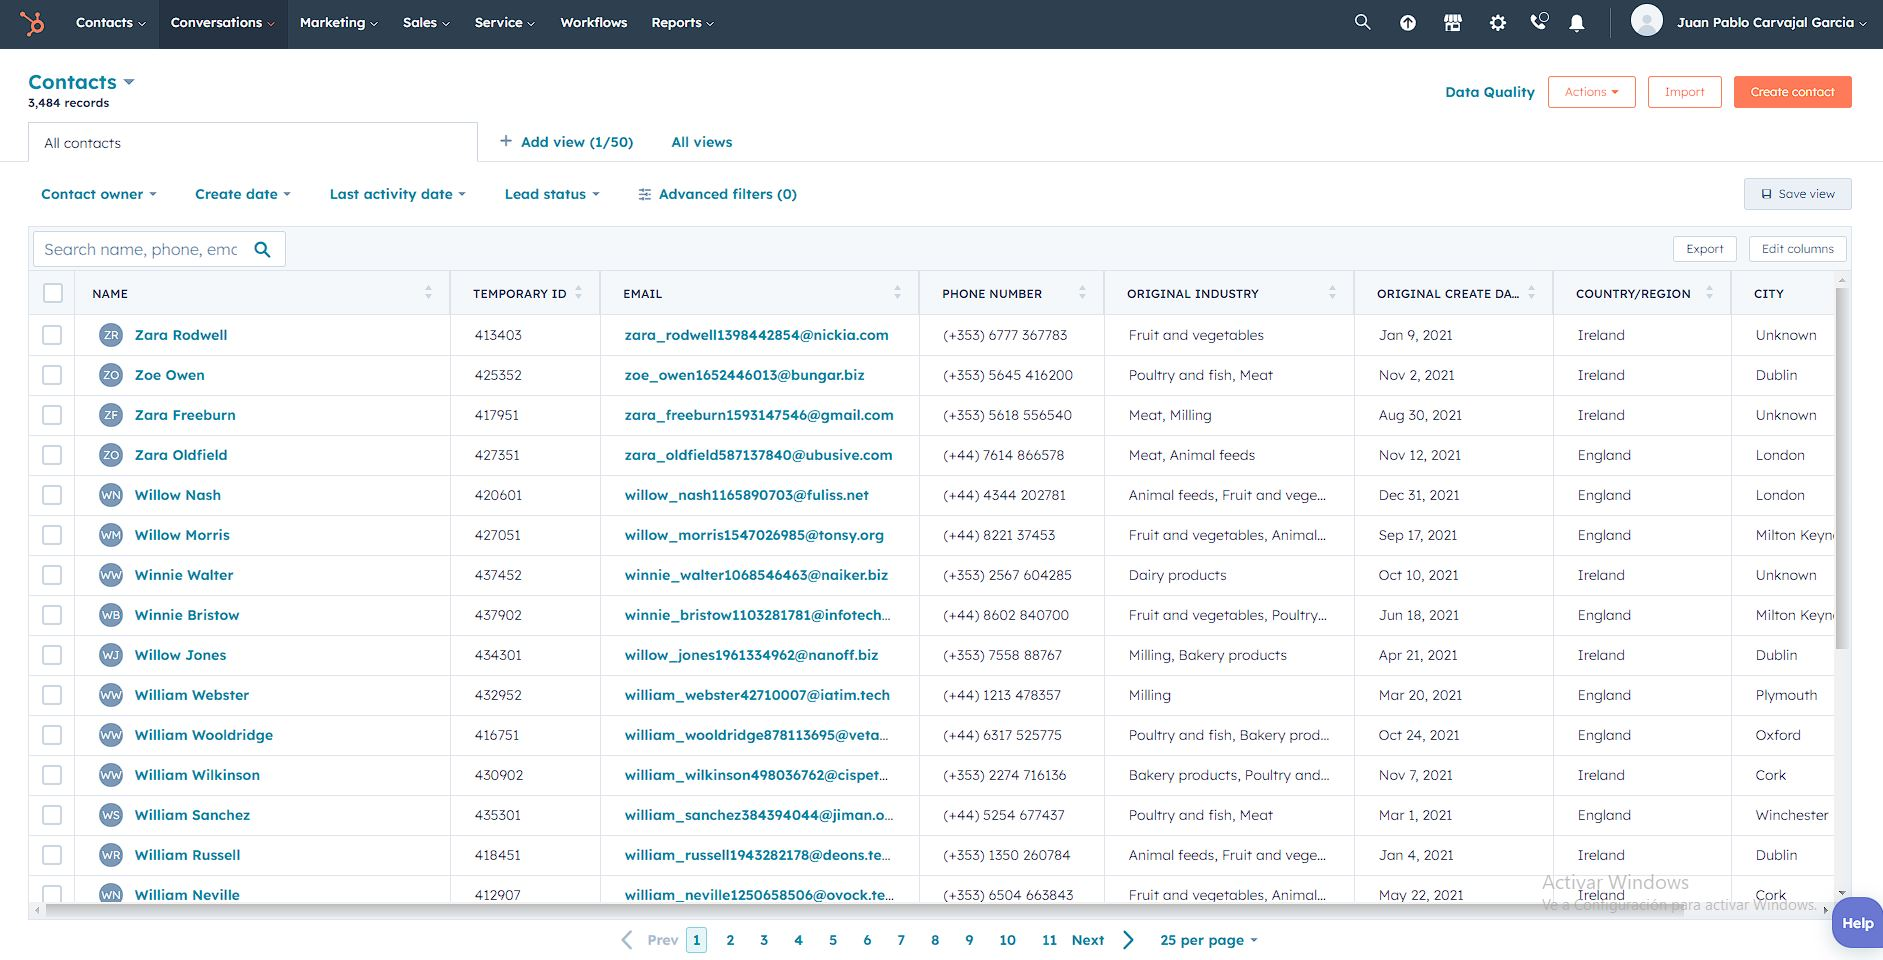

And the api calls to the private app that I set up.

![Api calls.JPG](<attachment:Api calls.JPG>)
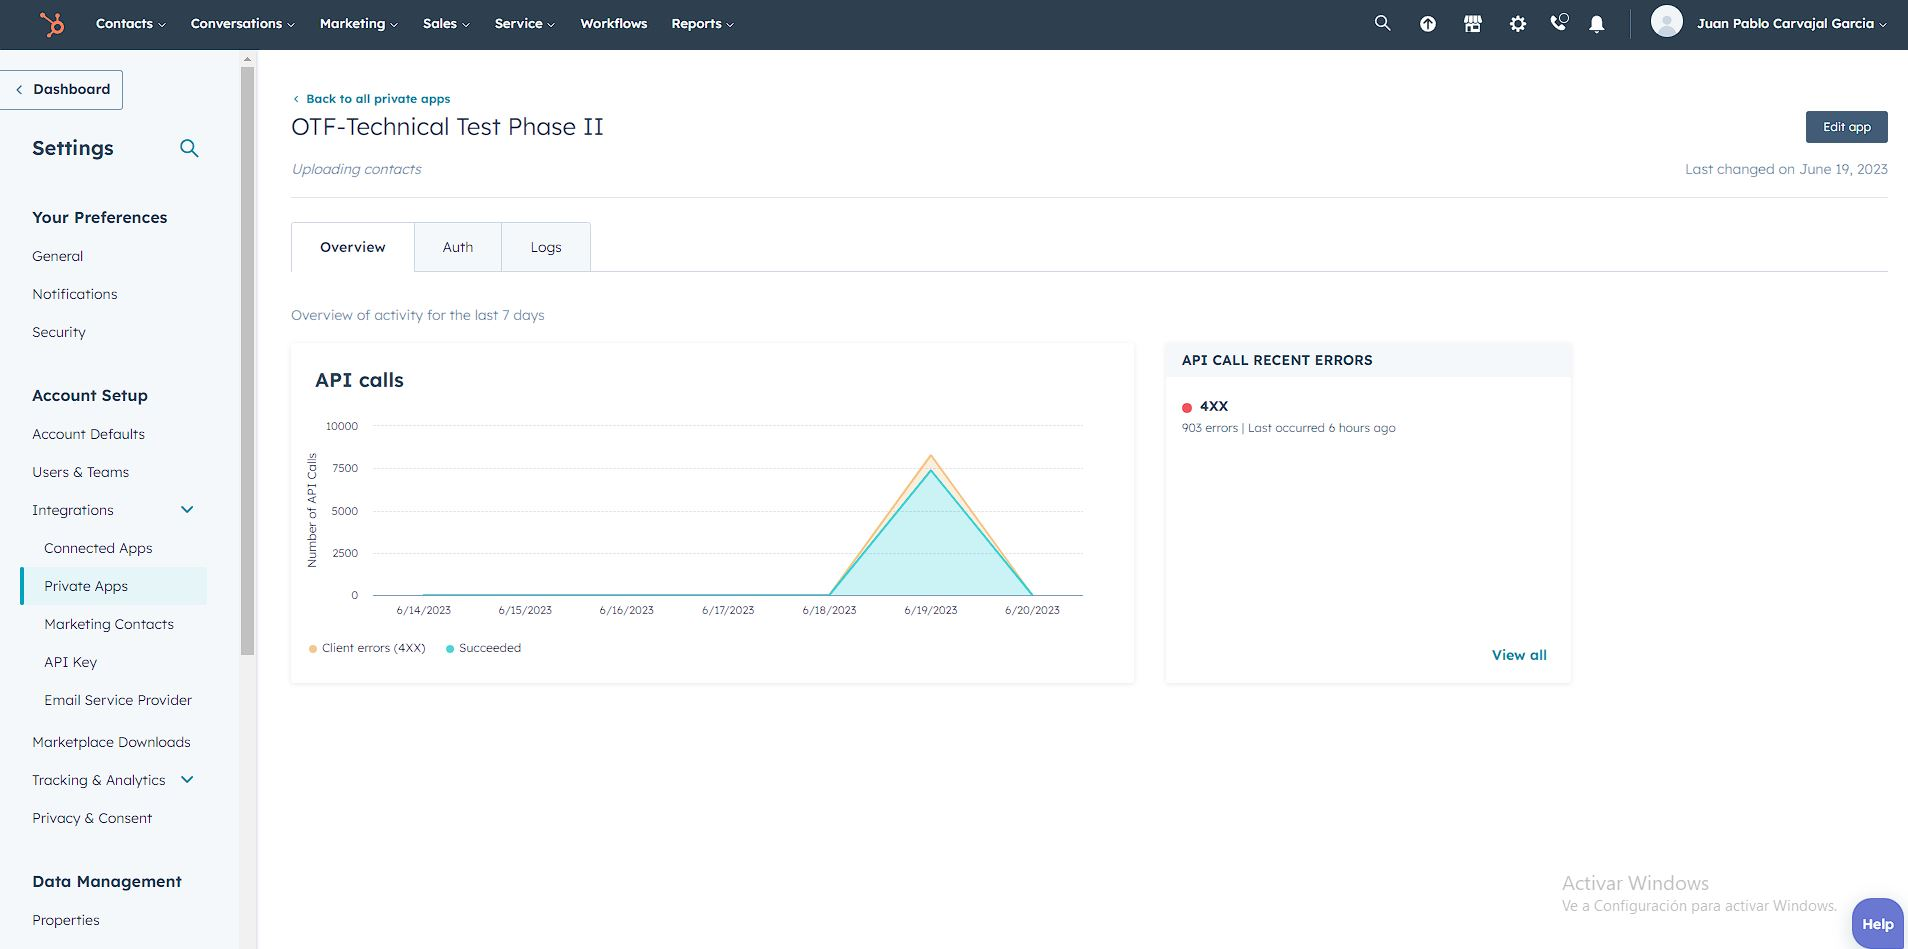

## Idea about Street Adrees and “Technical Test - Create Date”

By going through the field types that Hubspot offers I didn't see any that could store this relationship directly, so the only 2 ideas that comes to mind is to save all of the addresses and their respective Technical Test - Create Date in a single-line text field, separating each street adress and create date by an specific character like % and then separating each tuple with another character like $, or just using a multi-line text field type, separating each adress and create date as before, with an specific character, but each tuple with a new line, this way the field would be somewhat readable and useful if getting it through an api, like on this ETL, besides the multi-line text field accepts a maximum of 10.000 characters from what I could check so I feel this would be a good solution.

## Table of questions

### What is your usual IDE?
My usual IDE is visual studio code
### What are the advantages of this IDE over the others?
It has support for pretty much all of the languages that I need, providing a really nice flexibility and after setting it up and using it's tools and extensions (without going overboard) it has let me handle all of the projects that I've worked on (except for java, in that case I prefer a dedicated IDE) although I recognize that this might be that I mainly work on relatively small projects and that for bigger ones, an IDE could be a better option. In terms of working on ipynb files I prefer working on Google Colab but it's just due to familiarity since I had to use it for some deep learning projects, on which the computer power that they provide it's really useful.
### Which of the items resulted in the most computational time for you? Add time in seconds.
The loading of the data, the total time or "wall time" was 1683s and it's cpu time was 95s.
### If you have any public portfolio (e.g., IA, computer vision, data processing…), please share the link with us
Not really, the projects that I've worked on were for my university and meant to meet specific requirements and I haven't adapted them for good practices or showing them in general.
